## Practical work in AI

1. Image preprocessing

The images are not sorted in the right way: can't figure out which domain belongs to which images.
I wrote a script to perform sorting based on the domain names that are present in the UNPROCESSED Retouch images.
Now, I have a list of dicts for the source images and a list of dicts for the target images.

2. Image augmentation

    Main problem currently: SVD is slow (0.6 seconds/image just for the decomposition!)
    the entire dataset in batches of 16, dataloading alone takes more than 5 minutes!

    

3. Training

    How many output channels does my network? 2? How many classes do I actually have? i guess 3, since in the paper they use 3 biomarkers
       

In [1]:
import numpy as np

from pathlib import Path
import os
from typing import *
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler

import monai
from monai.networks.nets import BasicUNetPlusPlus
from monai.transforms import *
from monai.config.type_definitions import KeysCollection

import albumentations as A

import wandb

# Imports from local files
from transforms import *
from dataset import OCTDatasetPrep, MakeDataset
from utils import *


# Set random seed
np.random.seed(99)
torch.manual_seed(99)

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: moritsih. Use `wandb login --relogin` to force relogin


True

## Paths to the data

In [18]:
class Config():

    def __init__(self):

        # paths
        # directory where img folders are still sorted by domain (but unprocessed OCT images)
        self.name_dir = Path(Path.cwd() / 'data/RETOUCH/TrainingSet-Release/') 
        # already processed OCT images but unsorted by domain (sorting happens in dataset class)
        self.train_dir = Path(Path.cwd() / 'data/Retouch-Preprocessed/train') 
        self.model_path = Path(Path.cwd() / 'models')


        self.source_domains = ['Spectralis', 'Topcon', 'Cirrus']


        # transforms
        self.train_transforms = Compose([
                                        CustomImageLoader(keys=['img', 'label']), # if SVDNA should not be performed, uncomment this and comment the following two lines
                                        #SVDNA(keys=['img'], histogram_matching_degree=.5),
                                        #CustomImageLoader(keys=['label']),
                                        ConvertLabelMaskToChannel(keys=['label'], target_keys=["masks"]),
                                        ExpandChannelDim(keys=['img', 'label']),
                                        ToTensord(keys=['img', 'label', 'masks']),
                                        #Lambdad(keys=['img', 'label', 'masks'], func = lambda x: 2*(x - x.min()) / (x.max() - x.min()) - 1 ),  # -1 to 1 scaling
                                        NormalizeToZeroOne(keys=['img', 'label', 'masks']),
                                        Resized(keys=["img", "label", 'masks'], mode=["area", "nearest-exact", "nearest-exact"], spatial_size=[400, 1024]),
                                        RandZoomd(keys=["img", "label", 'masks'], mode=["area", "nearest-exact", "nearest-exact"], prob=0.3, min_zoom=0.5, max_zoom=1.5),
                                        RandAxisFlipd(keys=["img", "label", 'masks'], prob=0.3),
                                        RandAffined(keys=["img", "label", 'masks'], 
                                                    prob=0.3, 
                                                    shear_range=[0, 0],
                                                    translate_range=[0, 0],
                                                    rotate_range=[0, 0],
                                                    mode=["bilinear", "nearest", "nearest"], 
                                                    padding_mode="zeros"),      
                                        #Debugging(keys=['img', 'label', 'masks']),
                                        ])


        self.val_transforms = Compose([
                                        CustomImageLoader(keys=['img', 'label']),
                                        ConvertLabelMaskToChannel(keys=['label'], target_keys=["masks"]),
                                        ExpandChannelDim(keys=['img', 'label']),
                                        ToTensord(keys=['img', 'label', 'masks']),
                                        NormalizeToZeroOne(keys=['img', 'label', 'masks']),
                                        Resized(keys=["img", "label", 'masks'], mode=["area", "nearest-exact", "nearest-exact"], spatial_size=[400, 1024]),
                                    ])
        
        
        self.test_transforms = Compose([
                                        CustomImageLoader(keys=['img', 'label']),
                                        ConvertLabelMaskToChannel(keys=['label'], target_keys=["masks"]),
                                        ExpandChannelDim(keys=['img', 'label']),
                                        ToTensord(keys=['img', 'label', 'masks']),
                                        NormalizeToZeroOne(keys=['img', 'label', 'masks']),
                                        Resized(keys=["img", "label", 'masks'], mode=["area", "nearest-exact", "nearest-exact"], spatial_size=[400, 1024]),
                                    ])

        # device
        if torch.backends.mps.is_available():
            self.device = 'mps'
        elif torch.cuda.is_available():
            self.device = 'cuda'
        else:
            self.device = 'cpu'

        # models
        self.model_parameters_unet = {
            'spatial_dims': 2,
            'in_channels': 1,
            'out_channels': 4,
            'channels': (16, 32, 64, 128, 256),
            'strides': (2, 2, 2, 2),
            'num_res_units': 2,
            'bias': False,
            'dropout':0.1
        }


        self.model_parameters_unetpp = {
            'spatial_dims': 2,
            'out_channels': 4,
            'features': (32, 32, 64, 128, 256, 32)
        }


        # hyperparams
        self.batch_size = 24
        #self.lr = 1e-2 # hardcoded into optimizer for correct LR scheduling
        self.epochs = 100




In [19]:
# leftover transforms I keep for later
'''
    #GetMaskPositions(keys=['masks'], target_keys=["mask_positions"]), #We get the layer position, but on the original height
    #LayerPositionToProbabilityMap(["mask_positions"], target_size=(400,400), target_keys=["mask_probability_map"]),

    #Resized(keys=["img", "label", "masks"], mode=["area", "nearest-exact", "nearest-exact"], spatial_size=[400, 400]),
    #Lambdad(keys=['mask_positions'], func = lambda x: x * 400 / 800), #We scale down the positions to have more accurate positions
    #Lambdad(keys=['img'], func = lambda x: np.clip((x - x.mean()) / x.std(), -1, 1)), 
'''

'\n    #GetMaskPositions(keys=[\'masks\'], target_keys=["mask_positions"]), #We get the layer position, but on the original height\n    #LayerPositionToProbabilityMap(["mask_positions"], target_size=(400,400), target_keys=["mask_probability_map"]),\n\n    #Resized(keys=["img", "label", "masks"], mode=["area", "nearest-exact", "nearest-exact"], spatial_size=[400, 400]),\n    #Lambdad(keys=[\'mask_positions\'], func = lambda x: x * 400 / 800), #We scale down the positions to have more accurate positions\n    #Lambdad(keys=[\'img\'], func = lambda x: np.clip((x - x.mean()) / x.std(), -1, 1)), \n'

## Initialize Config

In [20]:
cfg = Config()

Training set: 3507
Validation set: 1001
Test set: 500


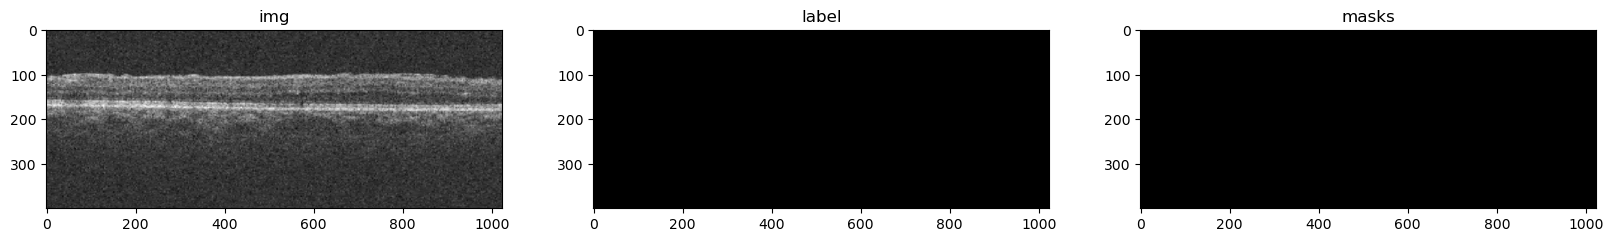

Sample 1 
Img:  torch.Size([1, 400, 1024]) 
Label:  torch.Size([1, 400, 1024]) 
Masks:  torch.Size([4, 400, 1024])


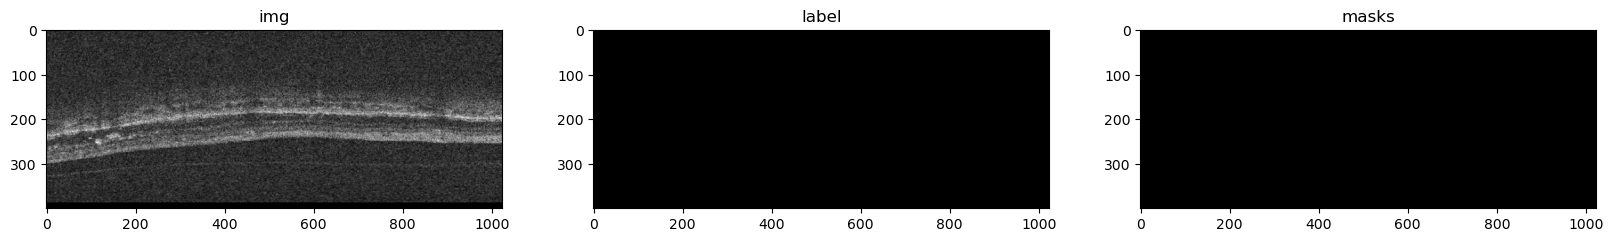

Sample 2 
Img:  torch.Size([1, 400, 1024]) 
Label:  torch.Size([1, 400, 1024]) 
Masks:  torch.Size([4, 400, 1024])


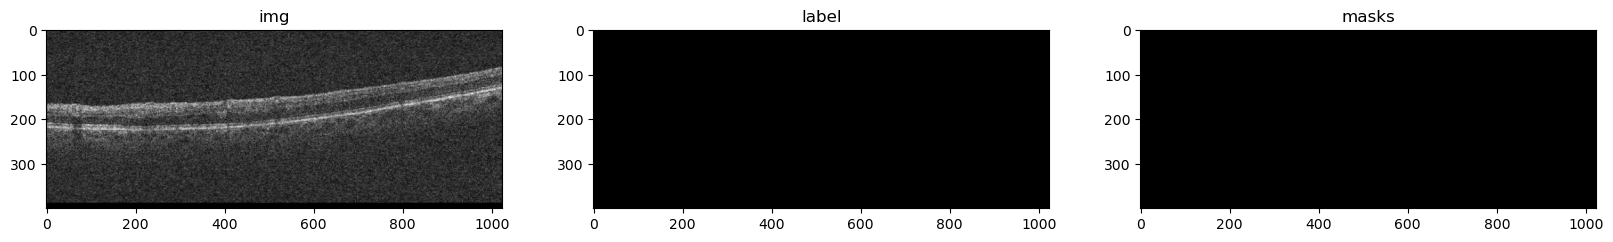

Sample 3 
Img:  torch.Size([1, 400, 1024]) 
Label:  torch.Size([1, 400, 1024]) 
Masks:  torch.Size([4, 400, 1024])


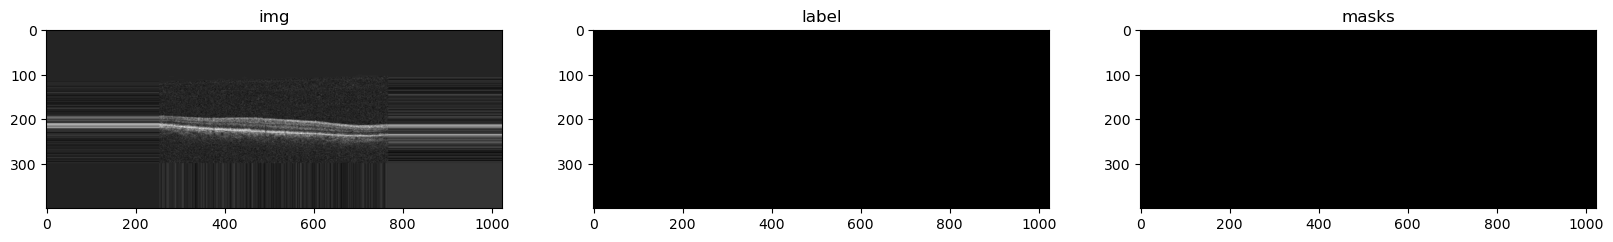

Sample 4 
Img:  torch.Size([1, 400, 1024]) 
Label:  torch.Size([1, 400, 1024]) 
Masks:  torch.Size([4, 400, 1024])


In [21]:
print_some_imgs = True

if print_some_imgs:
    
    transforms_visualize = Compose([cfg.train_transforms, ImageVisualizer(keys=['img', 'label', 'masks'])])
    train_data_raw, _, _ = OCTDatasetPrep(cfg.train_dir, source_domains=cfg.source_domains).get_datasets()
    train_data = MakeDataset(train_data_raw, transforms_visualize)
    for i in range(4):
 
        rand_num = np.random.randint(0, len(train_data))
        sample = train_data[rand_num]
        print(f"Sample {i+1}", 
              "\nImg: ", sample['img'].shape,
              "\nLabel: ", sample['label'].shape, 
              "\nMasks: ", sample['masks'].shape)



## Architecture, dataset, loss function, optimizer

In [22]:
if not os.path.isdir('models'):
    os.mkdir('models')

if not os.path.isdir('val_predictions'):
    os.mkdir('val_predictions')


print("Device: ", cfg.device)


model = monai.networks.nets.UNet(**cfg.model_parameters_unet)
#model = BasicUNetPlusPlus(**cfg.model_parameters_unetpp)

model = model.to(cfg.device)


#include background is important: we don't want the large amount of background pixels to dominate the loss
criterion = monai.losses.DiceLoss(sigmoid=True, include_background=False) 
optimizer = optim.Adam(model.parameters(), lr=5e-2)


# plotting LR at bottom of the notebook
start_lr = 1
end_lr = 1

scheduler1 = lr_scheduler.LinearLR(optimizer, start_lr, end_lr)
scheduler2 = lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.epochs/7, eta_min=1e-6) # cycle 7 times during training

scheduler = lr_scheduler.SequentialLR(optimizer, schedulers=[scheduler1, scheduler2], milestones=[30]) # switch to Cosine after 50 epochs


train_data, val_data, test_data = OCTDatasetPrep(cfg.train_dir).get_datasets(dataset_split=[0.02, 0.01, 0.97])

train_dataset = MakeDataset(train_data, cfg.train_transforms)
val_dataset = MakeDataset(val_data, cfg.val_transforms)
test_dataset = MakeDataset(test_data, cfg.test_transforms)

train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=0)


Device:  mps
Training set: 101
Validation set: 50
Test set: 4857


## Run the thing

In [28]:
#model = load_model(model, cfg.model_path / 'model_two_batches.pth')

wandb_config = {
    'batch_size': cfg.batch_size,
    'lr': optimizer.param_groups[0]['lr'],
    'epochs': cfg.epochs,
    'device': cfg.device,
    'model': 'UNet',
    'dataset': 'Retouch',
    'model_parameters': cfg.model_parameters_unet,
}

with wandb.init(project='PracticalWorkinAI', 
                config=wandb_config,
                name='Fixing erros!') as run:
    wandb_config = wandb.config
    
    model = train(model, 
                  train_loader, val_loader, 
                  criterion, optimizer, scheduler, cfg.device, 
                  epochs=cfg.epochs, 
                  save_path= cfg.model_path / 'model_trial.pth')

Training:   0%|          | 0/100 [00:00<?, ?epoch/s]

Batch 1/1, Loss: 0.9898


Training:   1%|          | 1/100 [00:10<16:53, 10.24s/epoch]

Batch 1/1, Loss: 0.9910


Training:   2%|▏         | 2/100 [00:17<14:15,  8.73s/epoch]

Batch 1/1, Loss: 0.9912


Training:   3%|▎         | 3/100 [00:26<14:15,  8.82s/epoch]

Batch 1/1, Loss: 0.9902


Training:   4%|▍         | 4/100 [00:37<15:20,  9.59s/epoch]

Batch 1/1, Loss: 0.9896


Training:   5%|▌         | 5/100 [00:45<14:25,  9.11s/epoch]

Batch 1/1, Loss: 0.9904


Training:   6%|▌         | 6/100 [00:57<15:34,  9.94s/epoch]

Batch 1/1, Loss: 0.9905


Training:   7%|▋         | 7/100 [01:08<15:55, 10.27s/epoch]

Batch 1/1, Loss: 0.9910


Training:   8%|▊         | 8/100 [01:17<15:07,  9.86s/epoch]

Batch 1/1, Loss: 0.9862


Training:   9%|▉         | 9/100 [01:26<14:34,  9.61s/epoch]

Batch 1/1, Loss: 0.9871


Training:  10%|█         | 10/100 [01:33<13:07,  8.75s/epoch]

Batch 1/1, Loss: 0.9882


Training:  11%|█         | 11/100 [01:44<13:58,  9.42s/epoch]

Batch 1/1, Loss: 0.9880


Training:  12%|█▏        | 12/100 [01:52<13:31,  9.22s/epoch]

Batch 1/1, Loss: 0.9878


Training:  13%|█▎        | 13/100 [02:00<12:44,  8.79s/epoch]

Batch 1/1, Loss: 0.9859


Training:  14%|█▍        | 14/100 [02:08<12:05,  8.44s/epoch]

Batch 1/1, Loss: 0.9830


Training:  15%|█▌        | 15/100 [02:16<11:40,  8.24s/epoch]

Batch 1/1, Loss: 0.9815


Training:  16%|█▌        | 16/100 [02:24<11:46,  8.41s/epoch]

Batch 1/1, Loss: 0.9815


Training:  17%|█▋        | 17/100 [02:31<10:54,  7.88s/epoch]

Batch 1/1, Loss: 0.9803


Training:  18%|█▊        | 18/100 [02:37<09:54,  7.25s/epoch]

Batch 1/1, Loss: 0.9798


Training:  19%|█▉        | 19/100 [02:44<09:49,  7.28s/epoch]

Batch 1/1, Loss: 0.9772


/Users/moritz/miniconda3/envs/optima/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Training:  20%|██        | 20/100 [02:52<10:02,  7.54s/epoch]

Batch 1/1, Loss: 0.9776


Training:  21%|██        | 21/100 [03:01<10:24,  7.90s/epoch]

Batch 1/1, Loss: 0.9773


Training:  22%|██▏       | 22/100 [03:10<10:39,  8.20s/epoch]

Batch 1/1, Loss: 0.9769


Training:  23%|██▎       | 23/100 [03:18<10:15,  7.99s/epoch]

Batch 1/1, Loss: 0.9740


Training:  24%|██▍       | 24/100 [03:26<10:17,  8.12s/epoch]

Batch 1/1, Loss: 0.9827


Training:  25%|██▌       | 25/100 [03:33<09:49,  7.86s/epoch]

Batch 1/1, Loss: 0.9723


Training:  26%|██▌       | 26/100 [03:39<09:02,  7.34s/epoch]

Batch 1/1, Loss: 0.9753


Training:  27%|██▋       | 27/100 [03:48<09:17,  7.63s/epoch]

Batch 1/1, Loss: 0.9781


Training:  28%|██▊       | 28/100 [03:56<09:27,  7.88s/epoch]

Batch 1/1, Loss: 0.9665


Training:  29%|██▉       | 29/100 [04:04<09:10,  7.75s/epoch]

Batch 1/1, Loss: 0.9708


Training:  30%|███       | 30/100 [04:12<09:26,  8.10s/epoch]

Batch 1/1, Loss: 0.9673


Training:  31%|███       | 31/100 [04:19<08:40,  7.54s/epoch]

Batch 1/1, Loss: 0.9767


Training:  32%|███▏      | 32/100 [04:26<08:32,  7.54s/epoch]

Batch 1/1, Loss: 0.9708


Training:  33%|███▎      | 33/100 [04:36<09:15,  8.29s/epoch]

Batch 1/1, Loss: 0.9690


Training:  34%|███▍      | 34/100 [04:45<09:18,  8.47s/epoch]

Batch 1/1, Loss: 0.9693


Training:  35%|███▌      | 35/100 [04:54<09:23,  8.67s/epoch]

Batch 1/1, Loss: 0.9660


Training:  36%|███▌      | 36/100 [05:03<09:13,  8.64s/epoch]

Batch 1/1, Loss: 0.9665


Training:  37%|███▋      | 37/100 [05:12<09:14,  8.80s/epoch]

Batch 1/1, Loss: 0.9601


Training:  38%|███▊      | 38/100 [05:21<09:04,  8.78s/epoch]

Batch 1/1, Loss: 0.9612


Training:  39%|███▉      | 39/100 [05:28<08:34,  8.43s/epoch]

Batch 1/1, Loss: 0.9654


Training:  40%|████      | 40/100 [05:36<08:09,  8.16s/epoch]

Batch 1/1, Loss: 0.9604


Training:  41%|████      | 41/100 [05:44<07:55,  8.06s/epoch]

Batch 1/1, Loss: 0.9585


Training:  42%|████▏     | 42/100 [05:53<08:05,  8.36s/epoch]

Batch 1/1, Loss: 0.9642


Training:  43%|████▎     | 43/100 [06:01<07:52,  8.28s/epoch]

Batch 1/1, Loss: 0.9646


Training:  44%|████▍     | 44/100 [06:08<07:27,  7.99s/epoch]

Batch 1/1, Loss: 0.9614


Training:  45%|████▌     | 45/100 [06:17<07:39,  8.36s/epoch]

Batch 1/1, Loss: 0.9610


Training:  46%|████▌     | 46/100 [06:27<07:57,  8.84s/epoch]

Batch 1/1, Loss: 0.9553


Training:  47%|████▋     | 47/100 [06:36<07:41,  8.71s/epoch]

Batch 1/1, Loss: 0.9689


Training:  48%|████▊     | 48/100 [06:44<07:32,  8.70s/epoch]

Batch 1/1, Loss: 0.9629


Training:  49%|████▉     | 49/100 [06:53<07:21,  8.65s/epoch]

Batch 1/1, Loss: 0.9531


Training:  50%|█████     | 50/100 [07:01<07:04,  8.48s/epoch]

Batch 1/1, Loss: 0.9524


Training:  51%|█████     | 51/100 [07:08<06:38,  8.13s/epoch]

Batch 1/1, Loss: 0.9472


Training:  52%|█████▏    | 52/100 [07:17<06:38,  8.31s/epoch]

Batch 1/1, Loss: 0.9518


Training:  53%|█████▎    | 53/100 [07:25<06:20,  8.10s/epoch]

Batch 1/1, Loss: 0.9745


Training:  54%|█████▍    | 54/100 [07:32<06:04,  7.92s/epoch]

Batch 1/1, Loss: 0.9576


Training:  55%|█████▌    | 55/100 [07:41<06:08,  8.18s/epoch]

Batch 1/1, Loss: 0.9553


Training:  56%|█████▌    | 56/100 [07:49<05:52,  8.00s/epoch]

Batch 1/1, Loss: 0.9788


Training:  57%|█████▋    | 57/100 [07:56<05:33,  7.76s/epoch]

Batch 1/1, Loss: 0.9588


Training:  58%|█████▊    | 58/100 [08:03<05:23,  7.70s/epoch]

Batch 1/1, Loss: 0.9626


Training:  59%|█████▉    | 59/100 [08:11<05:20,  7.82s/epoch]

Batch 1/1, Loss: 0.9613


Training:  60%|██████    | 60/100 [08:21<05:36,  8.42s/epoch]

Batch 1/1, Loss: 0.9604


Training:  61%|██████    | 61/100 [08:32<05:59,  9.22s/epoch]

Batch 1/1, Loss: 0.9541


Training:  62%|██████▏   | 62/100 [08:41<05:45,  9.09s/epoch]

Batch 1/1, Loss: 0.9524


Training:  63%|██████▎   | 63/100 [08:53<06:01,  9.76s/epoch]

Batch 1/1, Loss: 0.9651


Training:  64%|██████▍   | 64/100 [09:00<05:30,  9.17s/epoch]

Batch 1/1, Loss: 0.9645


Training:  65%|██████▌   | 65/100 [09:07<04:59,  8.56s/epoch]

Batch 1/1, Loss: 0.9580


Training:  66%|██████▌   | 66/100 [09:15<04:38,  8.20s/epoch]

Batch 1/1, Loss: 0.9490


Training:  67%|██████▋   | 67/100 [09:22<04:18,  7.83s/epoch]

Batch 1/1, Loss: 0.9564


Training:  68%|██████▊   | 68/100 [09:32<04:31,  8.48s/epoch]

Batch 1/1, Loss: 0.9460


Training:  69%|██████▉   | 69/100 [09:40<04:20,  8.40s/epoch]

Batch 1/1, Loss: 0.9418


Training:  70%|███████   | 70/100 [09:49<04:16,  8.56s/epoch]

Batch 1/1, Loss: 0.9408


Training:  71%|███████   | 71/100 [09:56<03:59,  8.27s/epoch]

Batch 1/1, Loss: 0.9421


Training:  72%|███████▏  | 72/100 [10:05<03:51,  8.27s/epoch]

Batch 1/1, Loss: 0.9470


Training:  73%|███████▎  | 73/100 [10:12<03:36,  8.03s/epoch]

Batch 1/1, Loss: 0.9443


Training:  74%|███████▍  | 74/100 [10:20<03:26,  7.93s/epoch]

Batch 1/1, Loss: 0.9486


Training:  75%|███████▌  | 75/100 [10:30<03:36,  8.64s/epoch]

Batch 1/1, Loss: 0.9268


Training:  76%|███████▌  | 76/100 [10:38<03:22,  8.43s/epoch]

Batch 1/1, Loss: 0.9392


Training:  77%|███████▋  | 77/100 [10:47<03:16,  8.53s/epoch]

Batch 1/1, Loss: 0.9419


Training:  78%|███████▊  | 78/100 [10:54<02:57,  8.09s/epoch]

Batch 1/1, Loss: 0.9307


Training:  79%|███████▉  | 79/100 [11:00<02:37,  7.48s/epoch]

Batch 1/1, Loss: 0.9377


Training:  80%|████████  | 80/100 [11:07<02:25,  7.26s/epoch]

Batch 1/1, Loss: 0.9290


Training:  81%|████████  | 81/100 [11:12<02:06,  6.64s/epoch]

Batch 1/1, Loss: 0.9307


Training:  82%|████████▏ | 82/100 [11:18<01:58,  6.60s/epoch]

Batch 1/1, Loss: 0.9351


Training:  83%|████████▎ | 83/100 [11:30<02:15,  7.97s/epoch]

Batch 1/1, Loss: 0.9557


Training:  84%|████████▍ | 84/100 [11:39<02:11,  8.23s/epoch]

Batch 1/1, Loss: 0.9269


Training:  85%|████████▌ | 85/100 [11:45<01:55,  7.72s/epoch]

Batch 1/1, Loss: 0.9413


Training:  86%|████████▌ | 86/100 [11:53<01:47,  7.64s/epoch]

Batch 1/1, Loss: 0.9346


Training:  87%|████████▋ | 87/100 [11:59<01:36,  7.40s/epoch]

Batch 1/1, Loss: 0.9347


Training:  88%|████████▊ | 88/100 [12:07<01:28,  7.35s/epoch]

Batch 1/1, Loss: 0.9375


Training:  89%|████████▉ | 89/100 [12:13<01:16,  6.94s/epoch]

Batch 1/1, Loss: 0.9298


Training:  90%|█████████ | 90/100 [12:21<01:12,  7.26s/epoch]

Batch 1/1, Loss: 0.9261


Training:  91%|█████████ | 91/100 [12:28<01:05,  7.33s/epoch]

Batch 1/1, Loss: 0.9260


Training:  92%|█████████▏| 92/100 [12:35<00:58,  7.35s/epoch]

Batch 1/1, Loss: 0.9154


Training:  93%|█████████▎| 93/100 [12:43<00:52,  7.43s/epoch]

Batch 1/1, Loss: 0.9279


Training:  94%|█████████▍| 94/100 [12:51<00:44,  7.47s/epoch]

Batch 1/1, Loss: 0.9249


Training:  95%|█████████▌| 95/100 [12:57<00:35,  7.10s/epoch]

Batch 1/1, Loss: 0.9250


Training:  96%|█████████▌| 96/100 [13:05<00:30,  7.51s/epoch]

Batch 1/1, Loss: 0.9361


Training:  97%|█████████▋| 97/100 [13:13<00:22,  7.66s/epoch]

Batch 1/1, Loss: 0.9127


Training:  98%|█████████▊| 98/100 [13:20<00:14,  7.45s/epoch]

Batch 1/1, Loss: 0.9632


Training:  99%|█████████▉| 99/100 [13:30<00:08,  8.24s/epoch]

Batch 1/1, Loss: 0.9383


Training: 100%|██████████| 100/100 [13:39<00:00,  8.19s/epoch]
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


best_loss,████▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr,▁▂▃▄▅▆▇▇██▇▆▄▂▂▁▁▂▂▄▅▇▇██▇▆▅▃▂▁▁▁▂▃▄▆▇██
train_loss,██████▇▇▇▆▆▇▅▆▅▅▅▅▅▅▄▆▄▅▅▅▃▃▃▃▂▂▂▄▂▂▁▁▂▂
val_loss,████▇▇▇▆▆▆▆▅▅▅▄▄▄▄▄▃▃▃▇▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▂▁
best_loss,0.83981
epoch,100
lr,0.05
train_loss,0.93832
val_loss,0.84185


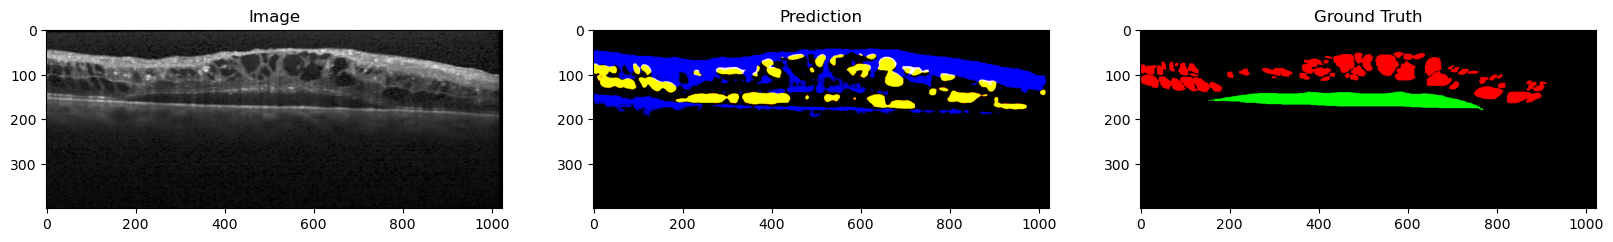

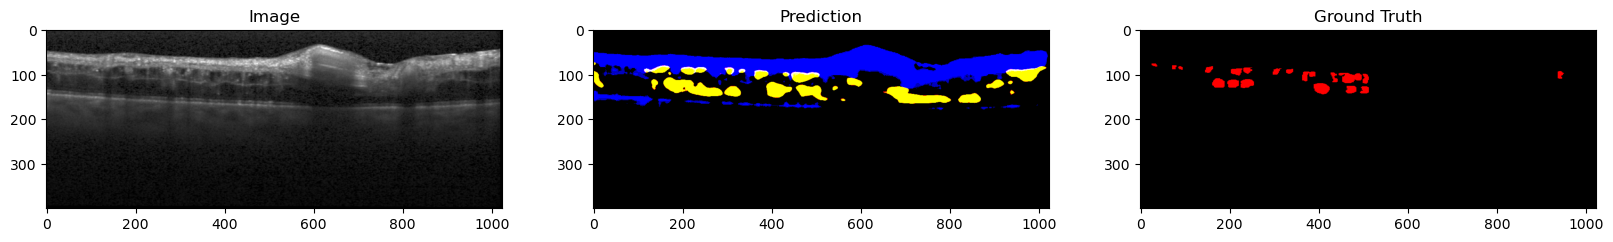

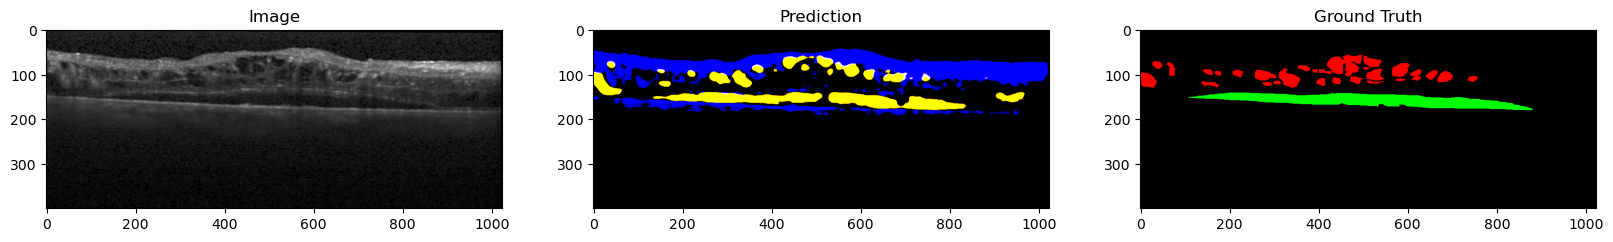

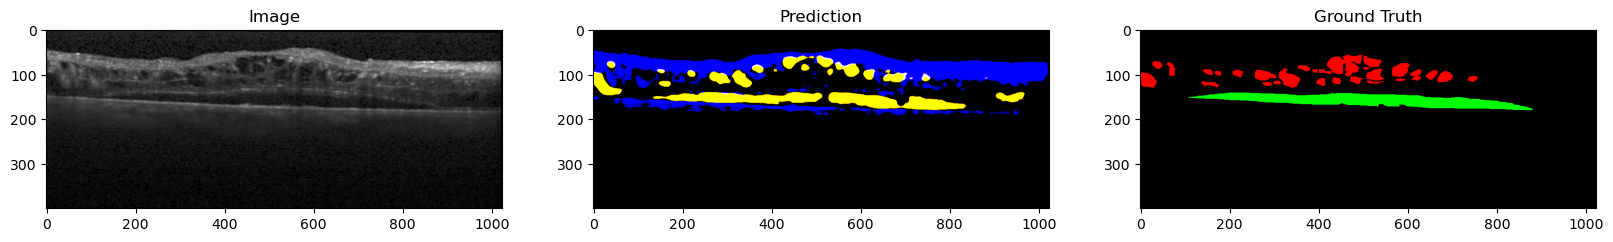

In [29]:
# load saved model and make predictions on random images from the validation set
model = load_model(model, cfg.model_path / 'model_trial.pth')
model.eval()

for i in range(4):
    rand_num = np.random.randint(0, len(val_dataset))
    sample = val_dataset[rand_num]

    img = sample['img'].unsqueeze(0).to(cfg.device)
    mask = sample['masks'].unsqueeze(0).to(cfg.device)

    pred = model(img)
    pred = torch.sigmoid(pred)
    
    # thresholding
    pred[pred > 0.5] = 1
    pred[pred <= 0.5] = 0

    plot_img_label_pred(img, pred, mask)

[0.05]
[0.05]
[0.05]
[0.05]
[0.05]
[0.05]
[0.05]
[0.05]
[0.05]
[0.05]
[0.05]
[0.05]
[0.05]
[0.05]
[0.05]
[0.05]
[0.05]
[0.05]
[0.05]
[0.05]
[0.05]
[0.05]
[0.05]
[0.05]
[0.05]
[0.05]
[0.05]
[0.05]
[0.05]
[0.05]
[0.05]
[0.04939793109008772]
[0.04762072389812426]
[0.04475398023188608]
[0.04093578103172238]
[0.03635003549823881]
[0.031217622834177804]
[0.02578575327157368]
[0.02031606082601419]
[0.01507200130807581]
[0.010306162585314324]
[0.0062480983147733355]
[0.003093271152243439]
[0.000993638004919262]
[5.033080265742518e-05]
[0.00030878532929185345]
[0.0017565527410366554]
[0.004323899183423093]
[0.007887164625335742]
[0.01227471912694858]
[0.0172752296491235]
[0.022647839221193792]
[0.028133768172490806]
[0.03346877863717216]
[0.03839590196107742]
[0.042677815976273105]
[0.046108275973587645]
[0.04852204878347117]
[0.0498028714755113]
[0.04988905133409472]
[0.04877643737912073]
[0.04651862030408512]
[0.04322435120122162]
[0.039052303404614366]
[0.03420342975484062]
[0.02891128340877

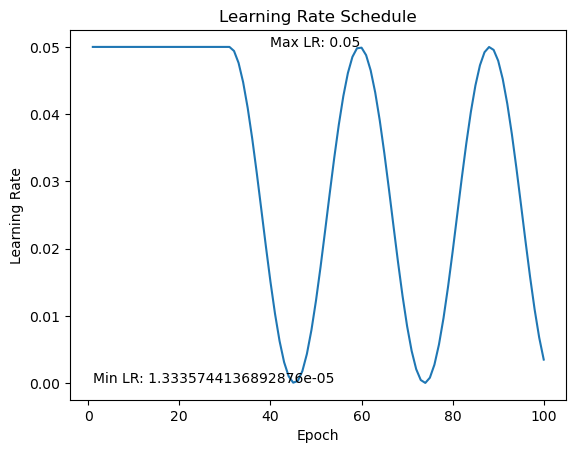

In [28]:
def plot_lr(optimizer, scheduler, num_steps):
    
    lr_values = []

    for i in range(num_steps):
        lr = scheduler.get_last_lr()
        print(lr)
        lr_values.append(lr)
        optimizer.step()
        scheduler.step()

    # Plot the learning rate values
    plt.plot(range(1, num_steps+1), lr_values)
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')

    # Add the maximum and minimum learning rate values
    max_lr = max(lr_values)[0]
    min_lr = min(lr_values)[0]

    plt.text(40, max_lr, f'Max LR: {max_lr}')
    plt.text(1, min_lr, f'Min LR: {min_lr}')

    plt.show()

model = monai.networks.nets.UNet(**cfg.model_parameters_unet)
optimizer = optim.Adam(model.parameters(), lr=5e-2)


start_lr = 1
end_lr = 1

scheduler1 = lr_scheduler.LinearLR(optimizer, start_lr, end_lr)
scheduler2 = lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.epochs/7, eta_min=1e-6) # cycle 7 times during training

scheduler = lr_scheduler.SequentialLR(optimizer, schedulers=[scheduler1, scheduler2], milestones=[30]) # switch to Cosine after 50 epochs

plot_lr(optimizer, scheduler, 100)